In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
data_dir = os.getenv('HOME')+'/workplace/aiffel/Exploration/08.Kaggle/data'
train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

print(train_data_path)
print(sub_data_path)

/home/aiffel0047/workplace/aiffel/Exploration/08.Kaggle/data/train.csv
/home/aiffel0047/workplace/aiffel/Exploration/08.Kaggle/data/test.csv


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [39]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape)) # price 가 없기 때문에 컬럼이 하나 적음

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [40]:
# 학습 데이터에서 라벨 제거하기
# price 컬럼은 따로 y라는 변수에 저장한 후 해당 컬럼 지워주기
y = data['price']

del data['price']

In [7]:
# 학습 데이터와 테스트 데이터 합치기: 전체 데이터 탐색을 위하여
train_len = len(data) # 추후 학습 데이터만 불러올 수 있는 인덱스로 사용
data = pd.concat((data, sub), axis=0)

In [8]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

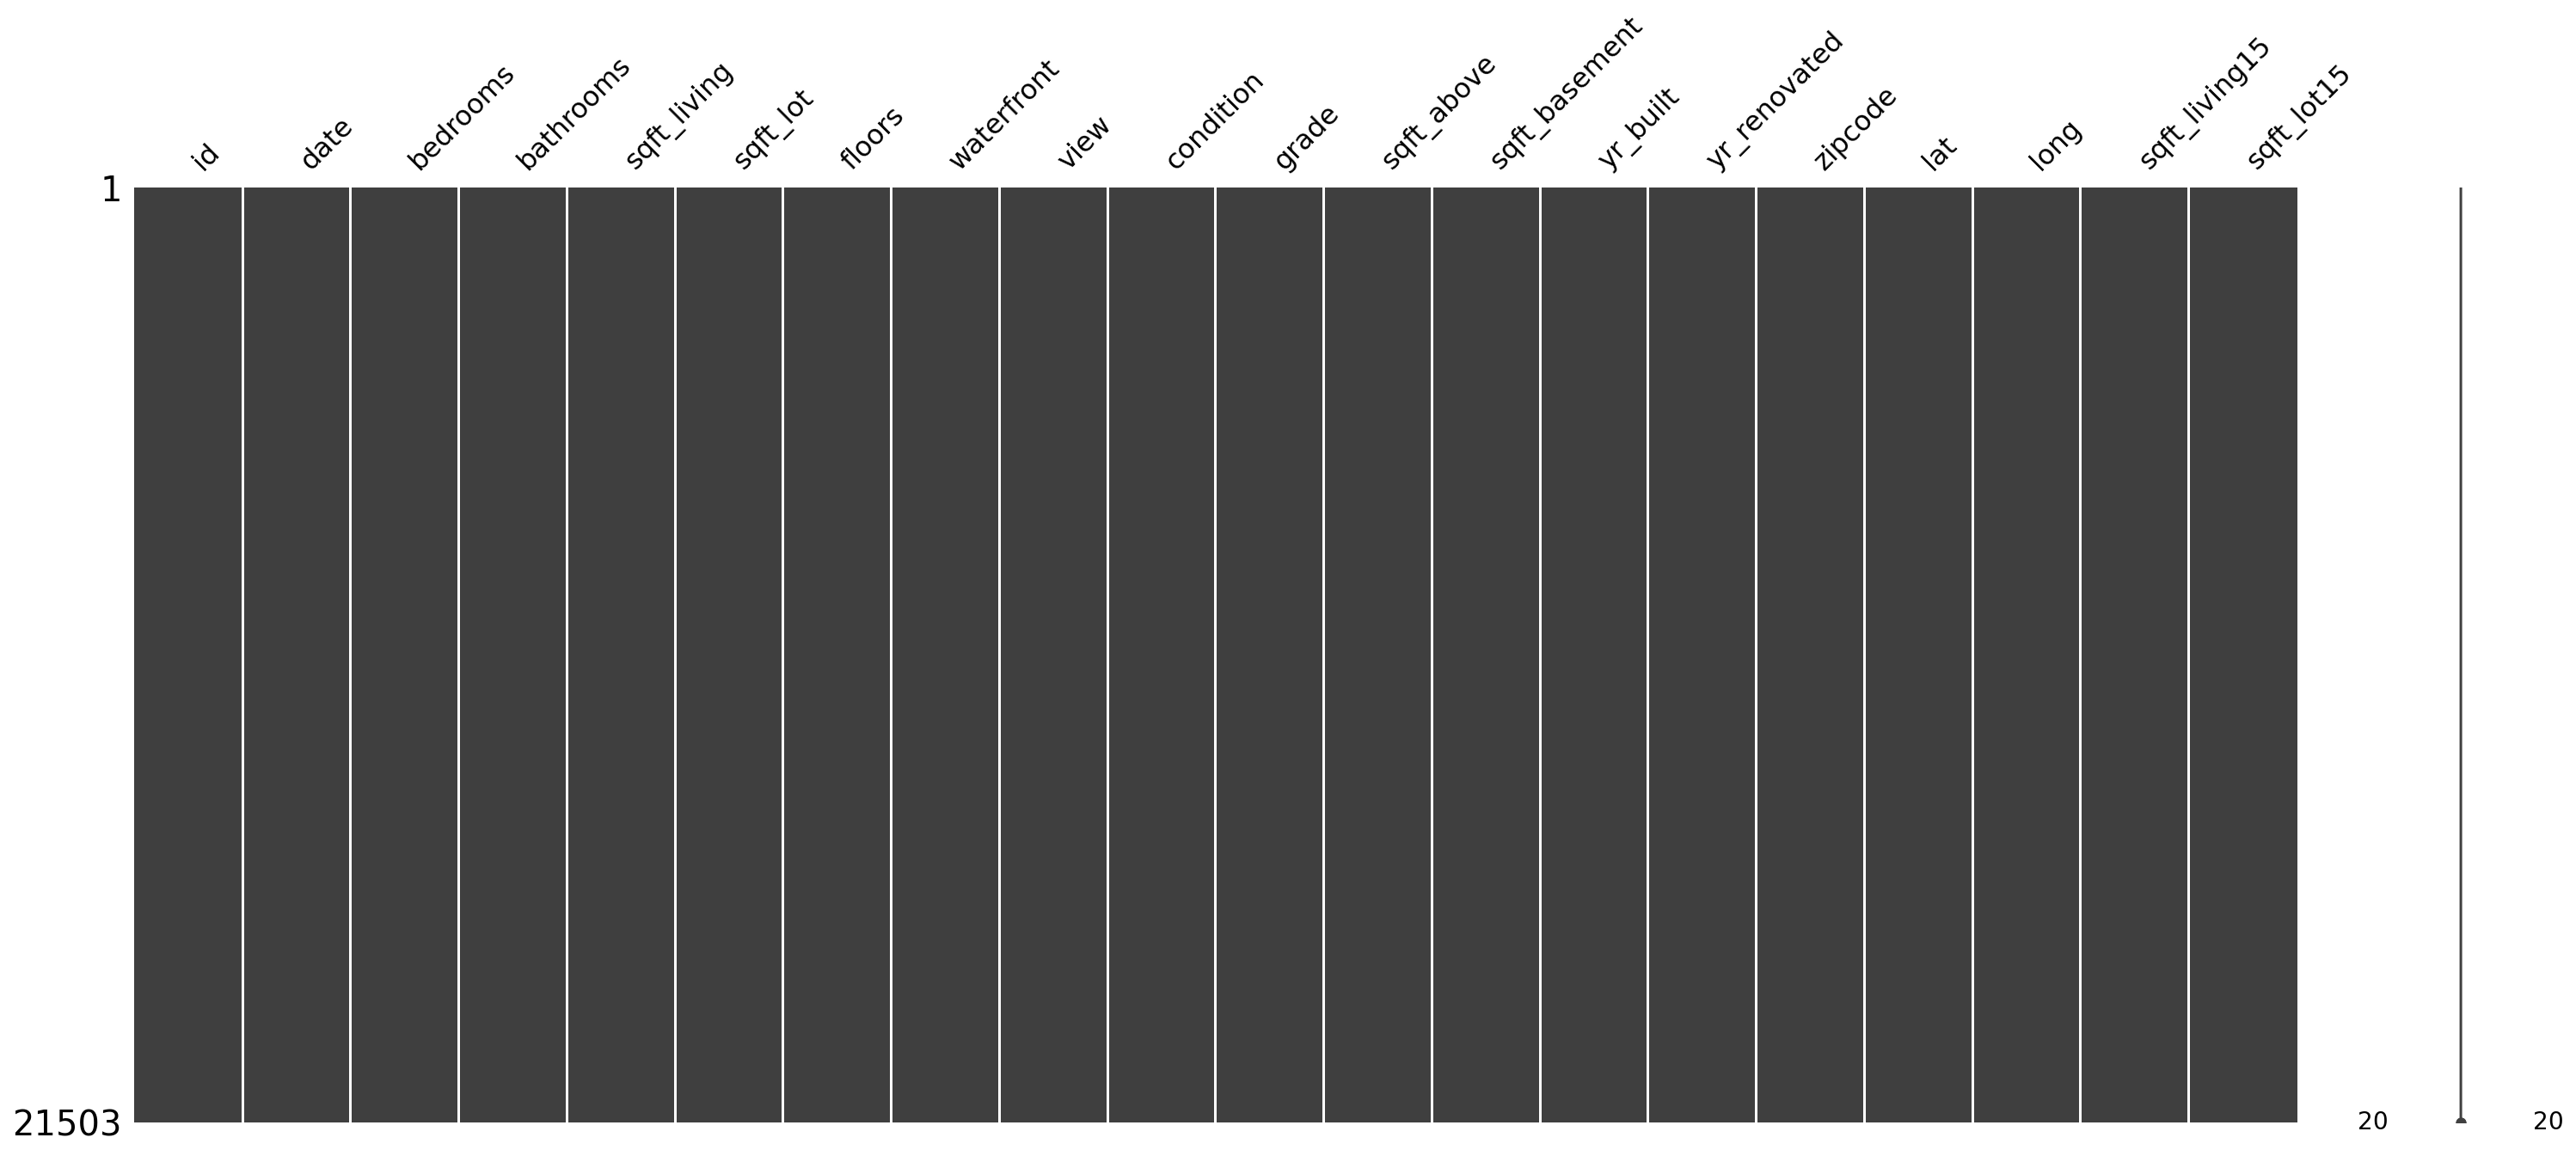

In [9]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [10]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [ ]:
sub_id = data['id'][train_len:] # 만일을 대비하여 저장
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str) # 필요한 부분만 자르기

In [20]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,0.625800,1.00,1.127738,1.183529,1.0,0,0,3,7,1.127738,0.0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,0.554618,1.00,1.110015,1.200992,1.0,0,0,3,6,1.110015,0.0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,0.625800,2.00,1.141499,1.194623,1.0,0,0,3,8,1.141499,0.0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,0.625800,2.25,1.142278,1.189426,2.0,0,0,3,7,1.142278,0.0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,0.625800,1.50,1.123404,1.200126,1.0,0,0,3,7,1.123404,0.0,1963,0,98198,47.4095,-122.315,1650,9711


### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

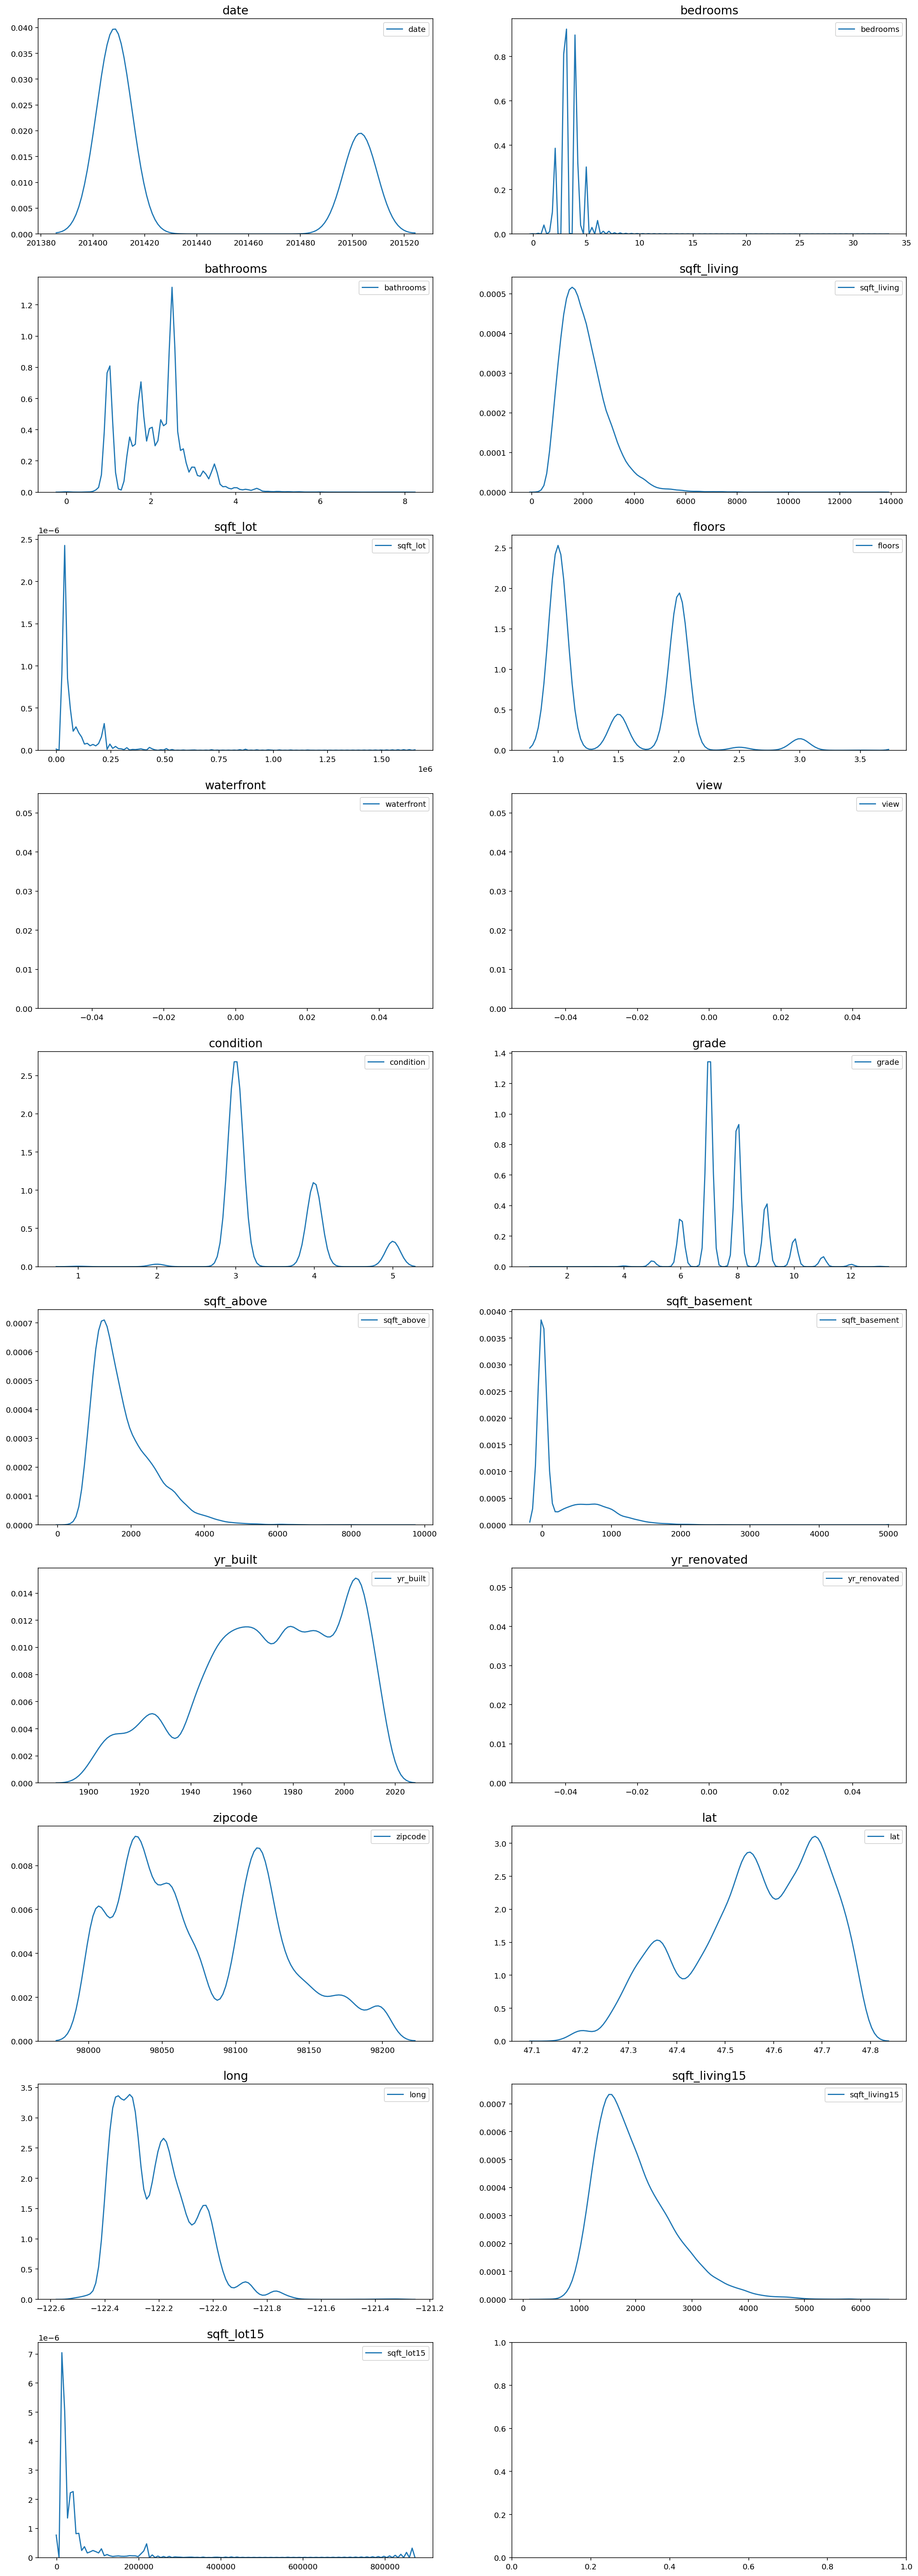

In [12]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])    # kdeplot은 이산 데이터도 부드러운 곡선으로 전체 분포 확인
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [21]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

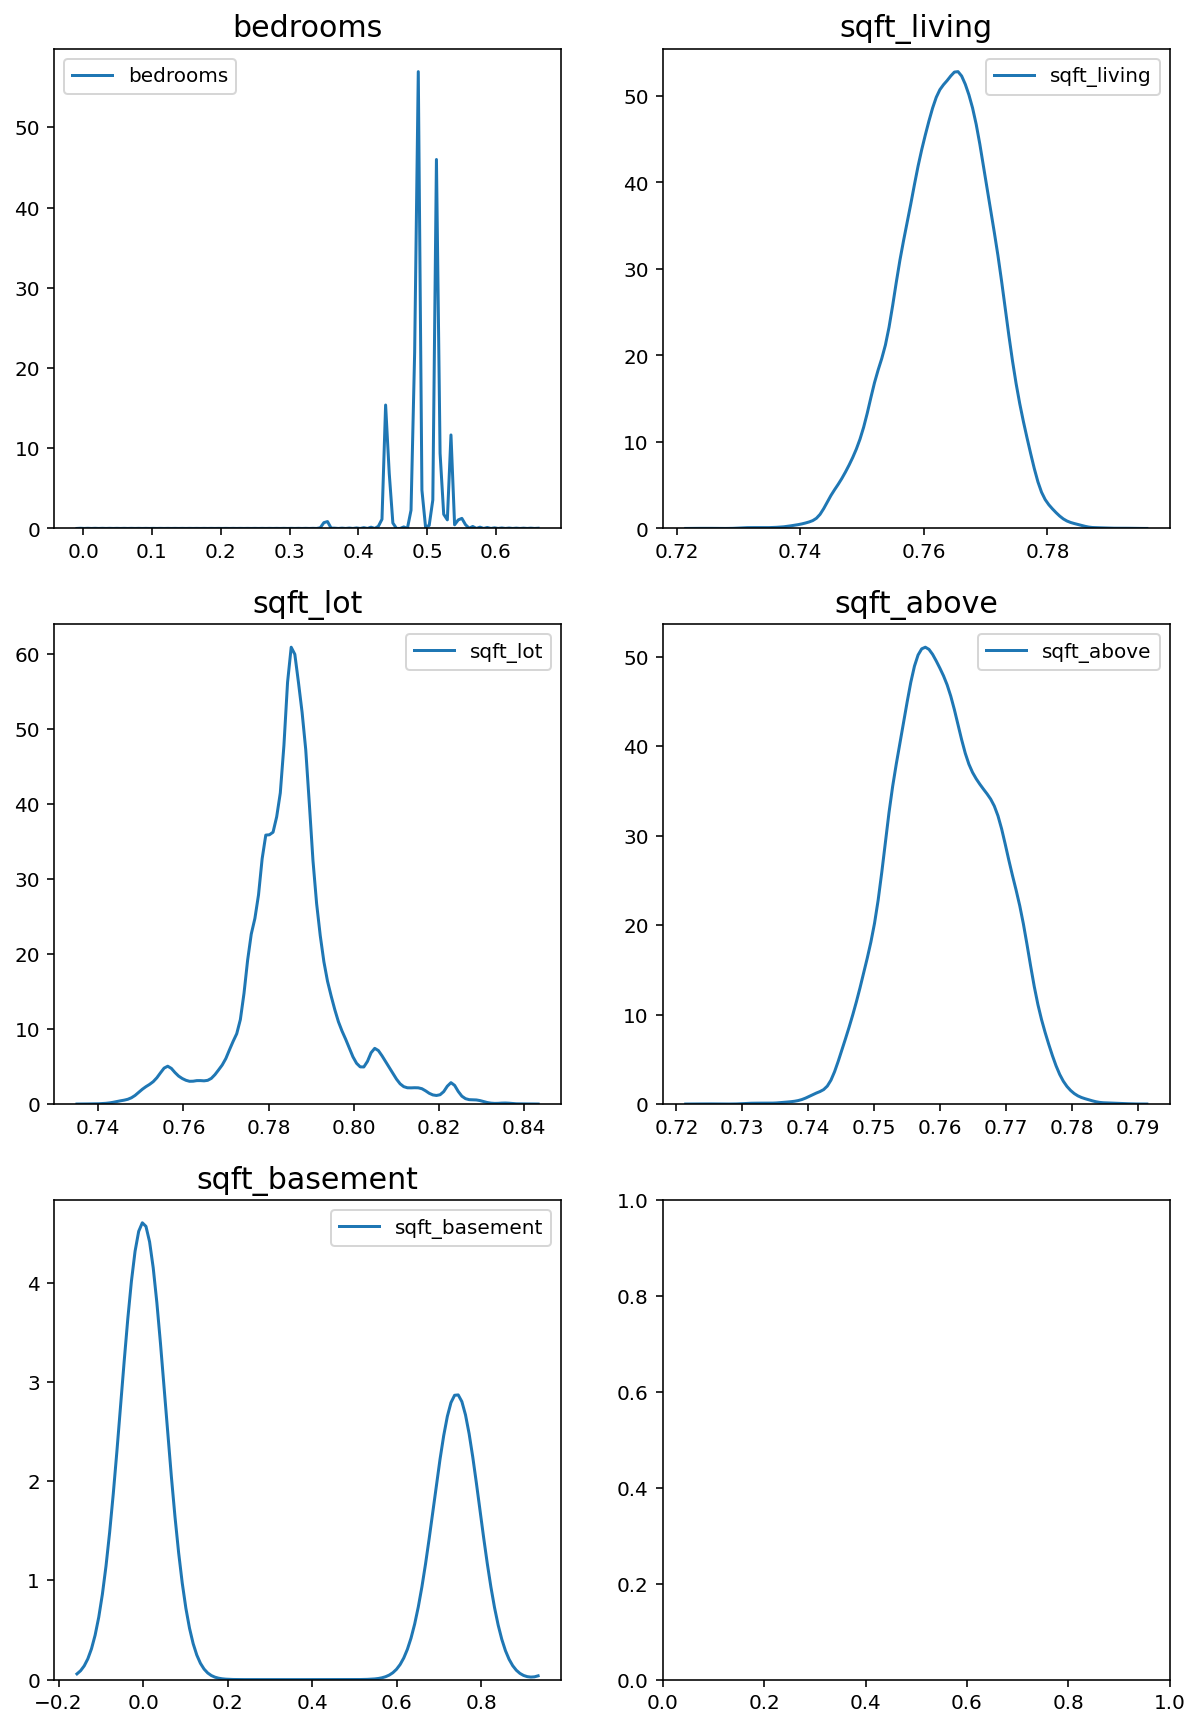

In [22]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

#### 2-1. 로그 변환이 분포의 치우침을 줄어들게 만드는 이유

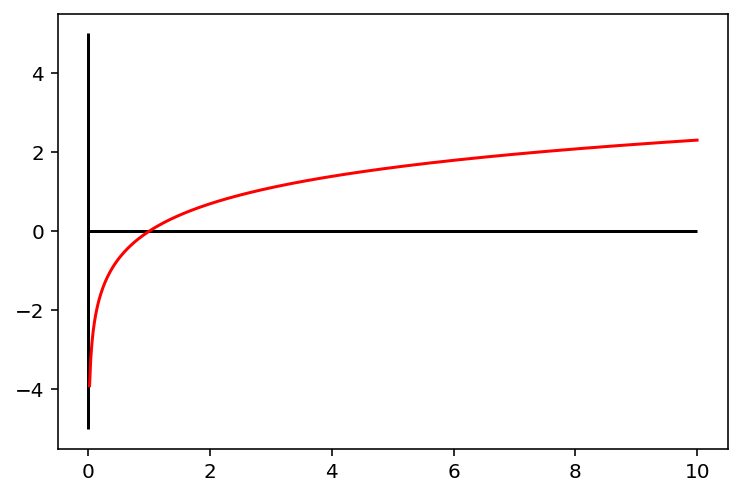

In [23]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

**2-2. 로그함수 특징**
- 0 < $x$ < 1 범위에서는 기울기가 매우 가파릅니다. 즉, x의 구간은 (0,1)로 매우 짧은 반면, y의 구간은 (-∞,0)으로 매우 크다.
- 따라서 0에 가깝게 모여있는 값들이 x로 입력되면, 그 함수값인 y값들은 매우 큰 범위로 벌어지게 됩니다. 즉, 로그 함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을 넓은 범위로 펼칠 수 있는 특징을 가진다.
- 반면, x값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아진다. 이는 곧 큰 x값들에 대해서는 y값이 크게 차이나지 않게 된다는 뜻이고, 따라서 넓은 범위를 가지는 x를 비교적 작은 y값의 구간 내에 모이게 하는 특징을 가진다.


- 위와 같은 특성 때문에 한 쪽으로 몰려있는 분포에 로그 변환을 취하게 되면 넓게 퍼질 수 있는 것이죠.

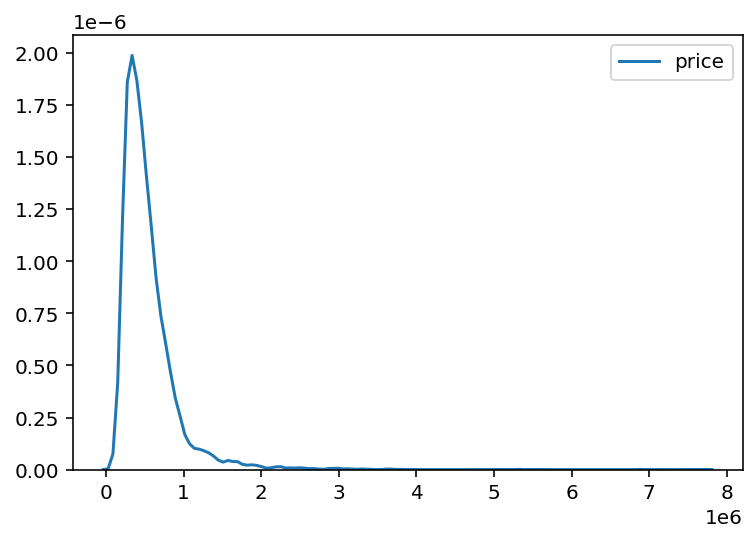

In [24]:
# 타겟인 prcie 의 분포를 로그 변환햇을 때 결과
sns.kdeplot(y)
plt.show()

- 위 분포는 0 쪽으로 매우 심하게 치우쳐져 있는 분포를 보인다. 

- 즉, 0과 1000000 사이에 대부분의 값들이 몰려있고, 아주 소수의 집들이 굉장히 높은 가격을 보인다.

- 따라서 이 분포에 로그 변환을 취하면, 0에 가깝게 몰려있는 데이터들은 넓게 퍼질 것이고, 매우 크게 퍼져있는 소수의 데이터들은 작은 y값으로 모일 것이다.

- 즉, 왼쪽으로 치우친 값들은 보다 넓은 범위로 고르게 퍼지고 오른쪽으로 얇고 넓게 퍼진 값들은 보다 작은 범위로 모이게 되므로 전체 분포는 정규분포의 형상을 띄는 방향으로 변환될 것이다.

#### 2-3. 로그 변환

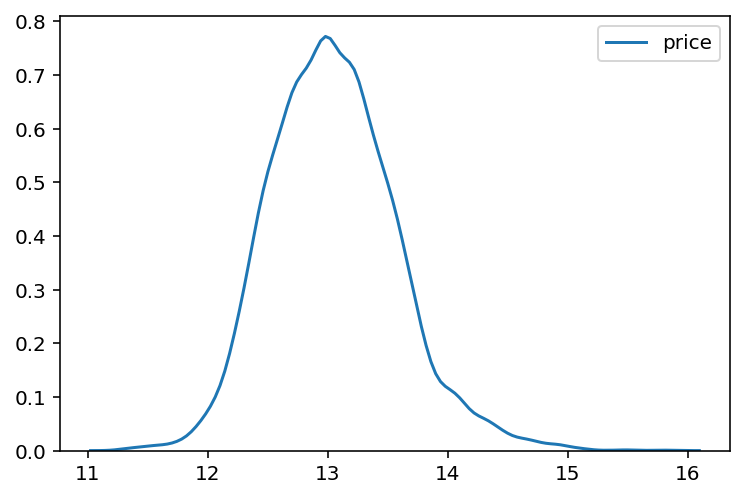

In [25]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

#### 2-4. 전체 데이터 다시 나누기

In [26]:
sub = data.iloc[train_len:, :] 
x = data.iloc[:train_len, :]

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.
- 여러 가지 모델을 함께 사용해서 결과를 섞는 기법, 앙상블
    - 앙상블(Ensemble) 학습은 여러 개의 학습 알고리즘을 사용하고, 그 예측을 결합함으로써 보다 정확한 최종 예측을 도출하는 기법입니다.

    - 하나의 강한 머신러닝 알고리즘보다 여러 개의 약한 머신러닝 알고리즘이 낫다는 아이디어로부터 시작되었습니다.
- Voting: 여러 모델이 분류해 낸 결과들로부터 말 그대로 다수결 투표를 통해 최종 결과를 선택하는 방법으로, 분류 문제에서 사용
- Averaging: 각 모델이 계산해 낸 실수값들을 평균 혹은 가중평균하여 사용하는 방법으로, 회귀 문제에서 사용

In [28]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [29]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))

In [30]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8597
Model XGBoost CV score : 0.8860
Model LightGBM CV score : 0.8819


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [34]:
# sample_submission.csv 확인
data_dir = os.getenv('HOME')+'/workplace/aiffel/Exploration/08.Kaggle/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [35]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [36]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/home/aiffel0047/workplace/aiffel/Exploration/08.Kaggle/data/submission.csv


In [31]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [32]:
y_pred = AveragingBlending(models, x, y, sub)

In [33]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [20]:
sub.to_csv('submission.csv', index=False)